 
# Witcher Character Network

Objectives:
1. Who are the most important characters?
2. How does their importance evolve throughout the series.
3. What are the main communities in this network?


In [55]:
import pandas as pd
import numpy as np
import scipy
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
!python3 -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.7 MB/s eta 0:00:000m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
#Load spacy English language model
NER = spacy.load("en_core_web_sm")
     

## Import text files

In [4]:
import os

all_books = [b for b in os.scandir('data') if '.txt' in b.name]

In [5]:
book = all_books[1]
book_text = open(book).read()
book_doc = NER(book_text)

In [6]:
# visualise identified entities

displacy.render(book_doc[:2000], style = 'ent', jupyter = True)


## Load Character names

In [7]:
#read characters
character_df = pd.read_csv('./data/character.csv')

In [8]:
character_df

,book,character
0,Baptism of Fire,Adalia
1,Baptism of Fire,Adela
2,Baptism of Fire,Aen Saevherne
3,Baptism of Fire,Aevenien
4,Baptism of Fire,Aglaïs
...,...,...
1270,Time of Contempt,Yanna of Murivel
1271,Time of Contempt,Yarpen Zigrin
1272,Time of Contempt,Yennefer of Vengerberg
1273,Time of Contempt,Yiolenta Suarez


### Cleaning the data
#some names have additional information or a title next to them, we should get rid of these so that we dont have duplicated characters in the datasheet

In [9]:
import re

In [37]:
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])
# I know that in this series sometimes a major character 'Ciri' is also called her given name 'Cirilla' I have combined these two names into one value.
character_df['character'] = character_df['character'].replace('Cirilla', 'Ciri') 

In [38]:
pd.set_option('display.max_rows', None)
character_df

,book,character,character_firstname
0,Baptism of Fire,Adalia,Adalia
1,Baptism of Fire,Adela,Adela
2,Baptism of Fire,Aen Saevherne,Aen
3,Baptism of Fire,Aevenien,Aevenien
4,Baptism of Fire,Aglaïs,Aglaïs
5,Baptism of Fire,Albrich,Albrich
6,Baptism of Fire,Amavet,Amavet
7,Baptism of Fire,Angus Bri Cri,Angus
8,Baptism of Fire,Anna Kameny,Anna
9,Baptism of Fire,Anzelm Aubry,Anzelm


## Get named entity list per sentence

In [39]:
sent_entity_df = []

# loop through sentences, store named entity list for each sentence.

for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence" : sent, "entities": entity_list})

sent_entity_df = pd.DataFrame(sent_entity_df)

In [40]:
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)
            ]
                                                

In [41]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

Some sentences do not have any named characters in at all. These sentences can be removed.

In [42]:
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]

sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
8,"(What, signs, these, shall, be, ,, I, say, unt...","[first, earth, Aen Seidhe, the Blood of Elves,...",[Aevenien]
14,"(Ciri, felt, the, knight, who, carried, her, b...",[Ciri],[Ciri]
18,"(Ciri, caught, a, glimpse, of, the, skirmish, ...",[Ciri],[Ciri]
64,"(Ciri, sees, his, eyes, gleaming, through, the...","[Ciri, prey]",[Ciri]
67,"(Ciri, is, unable, to, move, .)",[Ciri],[Ciri]
70,"(And, she, is, frozen, in, fear, :, a, terribl...",[Ciri],[Ciri]
130,"(Ciri, sees, his, eyes, gleaming, through, the...","[Ciri, prey]",[Ciri]
133,"(Ciri, is, unable, to, move, .)",[Ciri],[Ciri]
136,"(And, she, is, frozen, in, fear, :, a, terribl...",[Ciri],[Ciri]
163,"(Ciri, shuddered, violently, ,, curling, her, ...",[Ciri],[Ciri]


In [43]:
# Take only the first name. "Geralt of Rivia" should just be "Geralt"
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
                                                                                                               for item in x])

/tmp/ipykernel_3705/1015151038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [44]:
pd.reset_option('^display.', silent = True)
sent_entity_df_filtered

,sentence,entities,character_entities
8,"(What, signs, these, shall, be, ,, I, say, unt...","[first, earth, Aen Seidhe, the Blood of Elves,...",[Aevenien]
14,"(Ciri, felt, the, knight, who, carried, her, b...",[Ciri],[Ciri]
18,"(Ciri, caught, a, glimpse, of, the, skirmish, ...",[Ciri],[Ciri]
64,"(Ciri, sees, his, eyes, gleaming, through, the...","[Ciri, prey]",[Ciri]
67,"(Ciri, is, unable, to, move, .)",[Ciri],[Ciri]
...,...,...,...
10635,"(Take, care, of, her, ,, Yennefer, .)",[Yennefer],[Yennefer]
10639,"(Nenneke, did, not, look, at, \n, them, ., \n)",[Nenneke],[Nenneke]
10642,"(It, might, turn, out, to, be, true, ,, what, ...","[Ithlinne, Aevenien]","[Ithlinne, Aevenien]"
10645,"(Take, care, of, her, ,, Yennefer, .)",[Yennefer],[Yennefer]


## Create relationships

In [45]:
window_size = 5
relationships = []
for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i + 5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities),[])
    
    
    #remove duplicated characters that appear next to each other.
    char_unique = [char_list[i] for i in range(len(char_list))
                  if (i == 0) or char_list[i] != char_list[i - 1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [46]:
relationship_df = pd.DataFrame(relationships)
relationship_df

,source,target
0,Ciri,Geralt
1,Ciri,Geralt
2,Ciri,Geralt
3,Ciri,Geralt
4,Geralt,Yennefer
...,...,...
3777,Aevenien,Yennefer
3778,Yennefer,Ciri
3779,Yennefer,Ciri
3780,Yennefer,Ciri


In [47]:
#create weight/value column to show strength of the relationship including reversed relationships a > b & b > a

relationship_df["value"] = 1
relationship_df = relationship_df.groupby(['source','target'], sort = False, as_index = False).sum()

In [48]:
relationship_df.head()

,source,target,value
0,Ciri,Geralt,125
1,Geralt,Yennefer,57
2,Yennefer,Cirilla,5
3,Cirilla,Dandelion,4
4,Sheldon,Donimir,5


## Graph analysis and visualization

In [52]:
# create a graph from dataframe.

G = nx.from_pandas_edgelist(relationship_df, 
                           source = "source",
                           target = "target",
                           edge_attr = "value",
                           create_using = nx.Graph())

### Graph visualization - Networkx

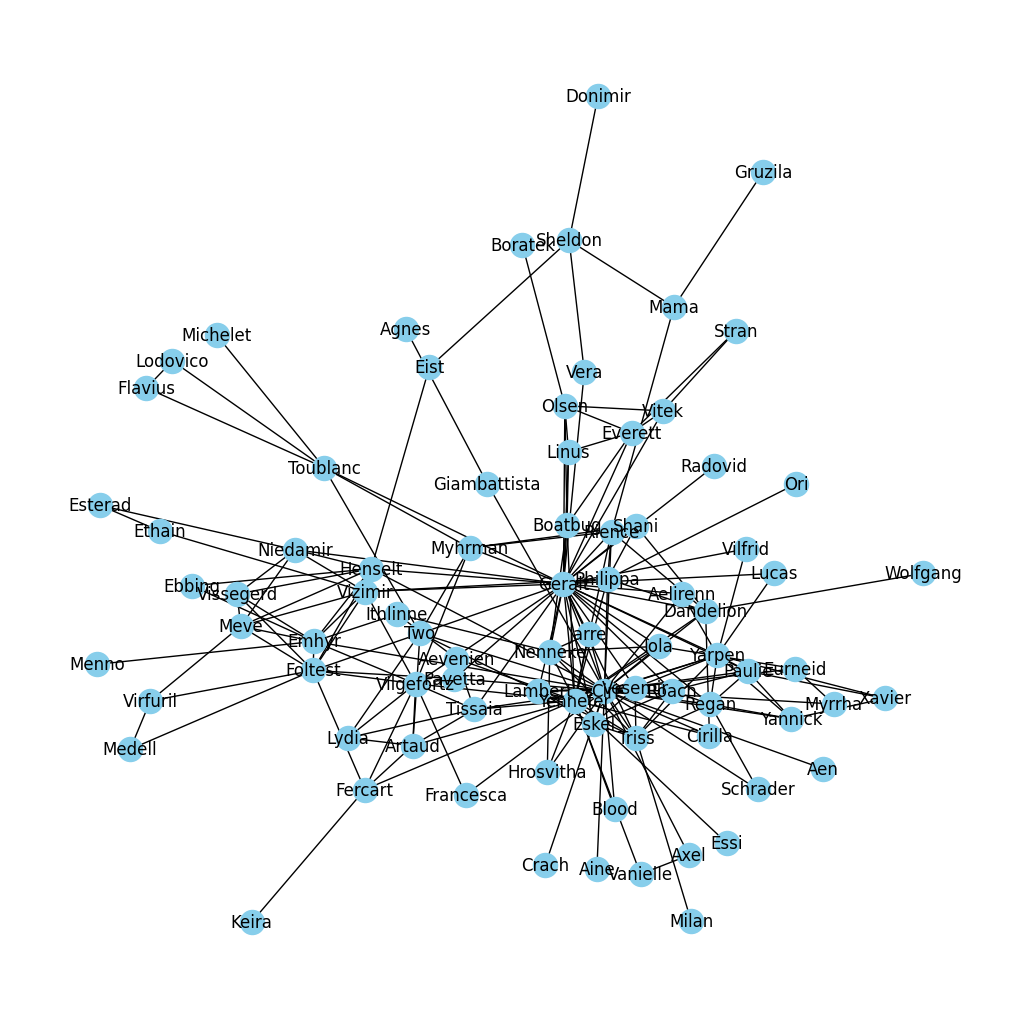

In [62]:
plt.figure(figsize = (10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels = True, node_color = 'skyblue')
plt.show()

## Graph visualization using pyvis

The network graph above is fine, but it's not quite clear what is going on, and is static making it hard to view characters whose nodes are stacked on top of one another.

In [69]:
from pyvis.network import Network
net = Network(notebook = True, width = "1000px", height = "700px", bgcolor = '#222222', font_color = 'white')

#change node size based on degree (number of edges) of node.

node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show('witcher.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### Who are the most important characters? (degree centrality)

<AxesSubplot: >

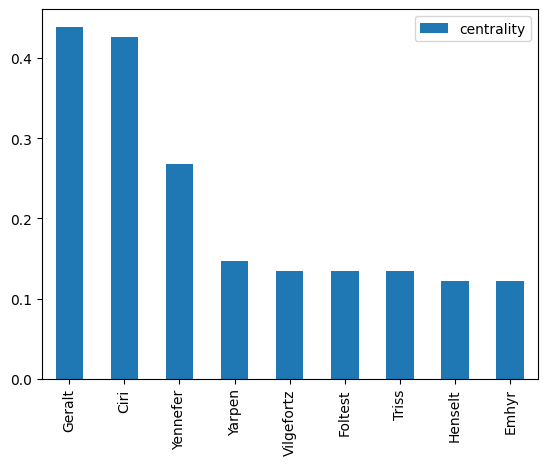

In [78]:
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient = 'index', columns = ['centrality'])
#plot top 10 nodes
degree_df.sort_values('centrality', ascending = False)[0:9].plot(kind='bar')

<AxesSubplot: >

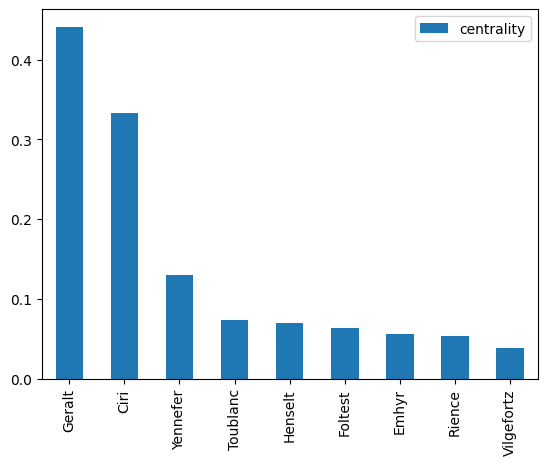

In [77]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient = 'index', columns = ['centrality'])
#plot top 10 
betweenness_df.sort_values('centrality', ascending = False)[0:9].plot(kind = 'bar')

<AxesSubplot: >

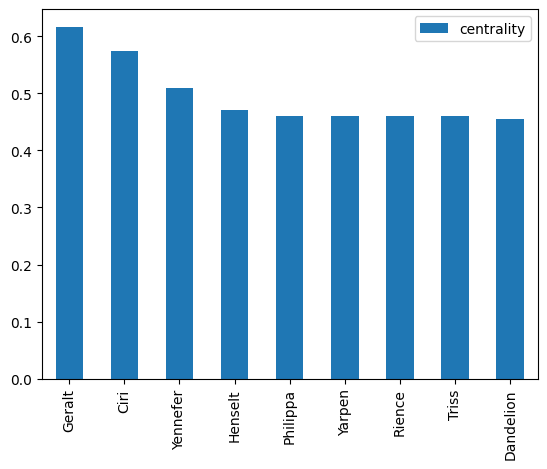

In [79]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient = 'index', columns = ['centrality'])
#plot top 10
closeness_df.sort_values('centrality', ascending = False)[0:9].plot(kind = 'bar')

In [80]:
#save centrality measures
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, degree_dict, 'degree centrality')

## Community detection

In [96]:
from community import community_louvain
partition = community_louvain.best_partition(G)

In [97]:
communities

{'Ciri': 0,
 'Geralt': 5,
 'Yennefer': 2,
 'Cirilla': 3,
 'Dandelion': 3,
 'Sheldon': 3,
 'Donimir': 3,
 'Vera': 3,
 'Pavetta': 0,
 'Eist': 3,
 'Mama': 3,
 'Rience': 3,
 'Gruzila': 3,
 'Niedamir': 1,
 'Roach': 0,
 'Eskel': 0,
 'Vesemir': 0,
 'Lambert': 0,
 'Triss': 0,
 'Two': 4,
 'Nenneke': 2,
 'Vanielle': 2,
 'Axel': 2,
 'Foltest': 1,
 'Fercart': 4,
 'Keira': 4,
 'Vilgefortz': 4,
 'Artaud': 4,
 'Milan': 0,
 'Yarpen': 0,
 'Yannick': 0,
 'Xavier': 0,
 'Paulie': 0,
 'Regan': 0,
 'Lucas': 0,
 'Vilfrid': 0,
 'Henselt': 1,
 'Schrader': 0,
 'Aelirenn': 0,
 'Radovid': 5,
 'Everett': 5,
 'Iola': 2,
 'Boatbug': 5,
 'Linus': 5,
 'Olsen': 5,
 'Boratek': 5,
 'Stran': 5,
 'Vitek': 5,
 'Shani': 3,
 'Ori': 3,
 'Philippa': 3,
 'Wolfgang': 3,
 'Vizimir': 1,
 'Emhyr': 1,
 'Ebbing': 1,
 'Meve': 1,
 'Ithlinne': 2,
 'Esterad': 1,
 'Ethain': 1,
 'Vissegerd': 1,
 'Virfuril': 1,
 'Medell': 1,
 'Menno': 1,
 'Myhrman': 4,
 'Toublanc': 4,
 'Flavius': 4,
 'Lodovico': 4,
 'Michelet': 4,
 'Tissaia': 4,
 'Lydia': 4,

In [98]:
nx.set_node_attributes(G, communities, 'group')

In [99]:

com_net = Network(notebook = True, width = '1000px', height = '700px', bgcolor = '#222222', font_color = 'white')
com_net.from_nx(G)
com_net.show('witcher_communities.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
